In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
from spaceoracle.models.estimators import GeoCNNEstimatorV2

In [4]:
import anndata
import matplotlib.pyplot as plt
import scanpy as sc

In [5]:
adata = anndata.read_h5ad('../data/slideseq/day3_1.h5ad')
# adata = anndata.read_h5ad('../data/slideseq/day3_2.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 15920 × 24649
    obs: 'cluster', 'rctd_cluster'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'

In [7]:
n_top_genes = 2000
min_cells = 10
min_counts = 300

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]
sc.pp.filter_genes(adata, min_cells=min_cells)

adata.layers["raw_count"] = adata.X

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, adata.var.highly_variable]
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


View of AnnData object with n_obs × n_vars = 10277 × 2000
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

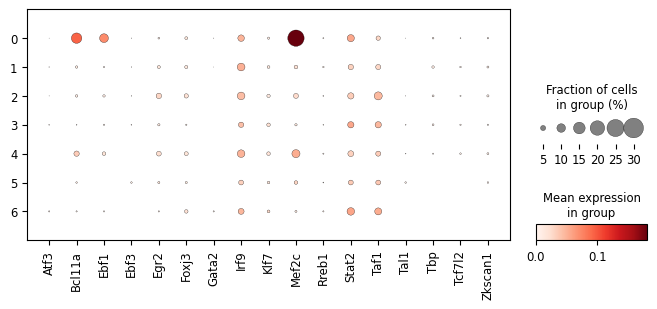

In [11]:
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams['figure.dpi'] = 100
sc.pl.dotplot(model.adata, var_names=model.regulators, 
    groupby='rctd_cluster', figsize=(8, 3))

In [10]:
estimator = GeoCNNEstimatorV2(adata, target_gene='Cd74')

In [12]:
estimator.fit(
    annot='rctd_cluster', 
    max_epochs=200, 
    learning_rate=3e-5, 
    spatial_dim=16,
    mode='train_test'
)

🌍️ Generating spatial maps: 100%|██████████| 10277/10277 [00:00<00:00, 16272.59it/s]
[mps] MSE: 0.3368 | Baseline: 0.4923: 100%|██████████| 200/200 [10:23<00:00,  3.12s/it]

Best model at 191/200


In [14]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.title('Validation loss')
plt.show()

AttributeError: 'GeoCNNEstimatorV2' object has no attribute 'losses'

In [22]:
import numpy as np
import seaborn as sns


In [20]:
betas = model.get_betas(
    np.array(adata.obsm['spatial']),
    np.array(adata.obs['rctd_cluster']),
)

🌍️ Generating spatial maps: 100%|██████████| 10277/10277 [00:00<00:00, 16214.72it/s]


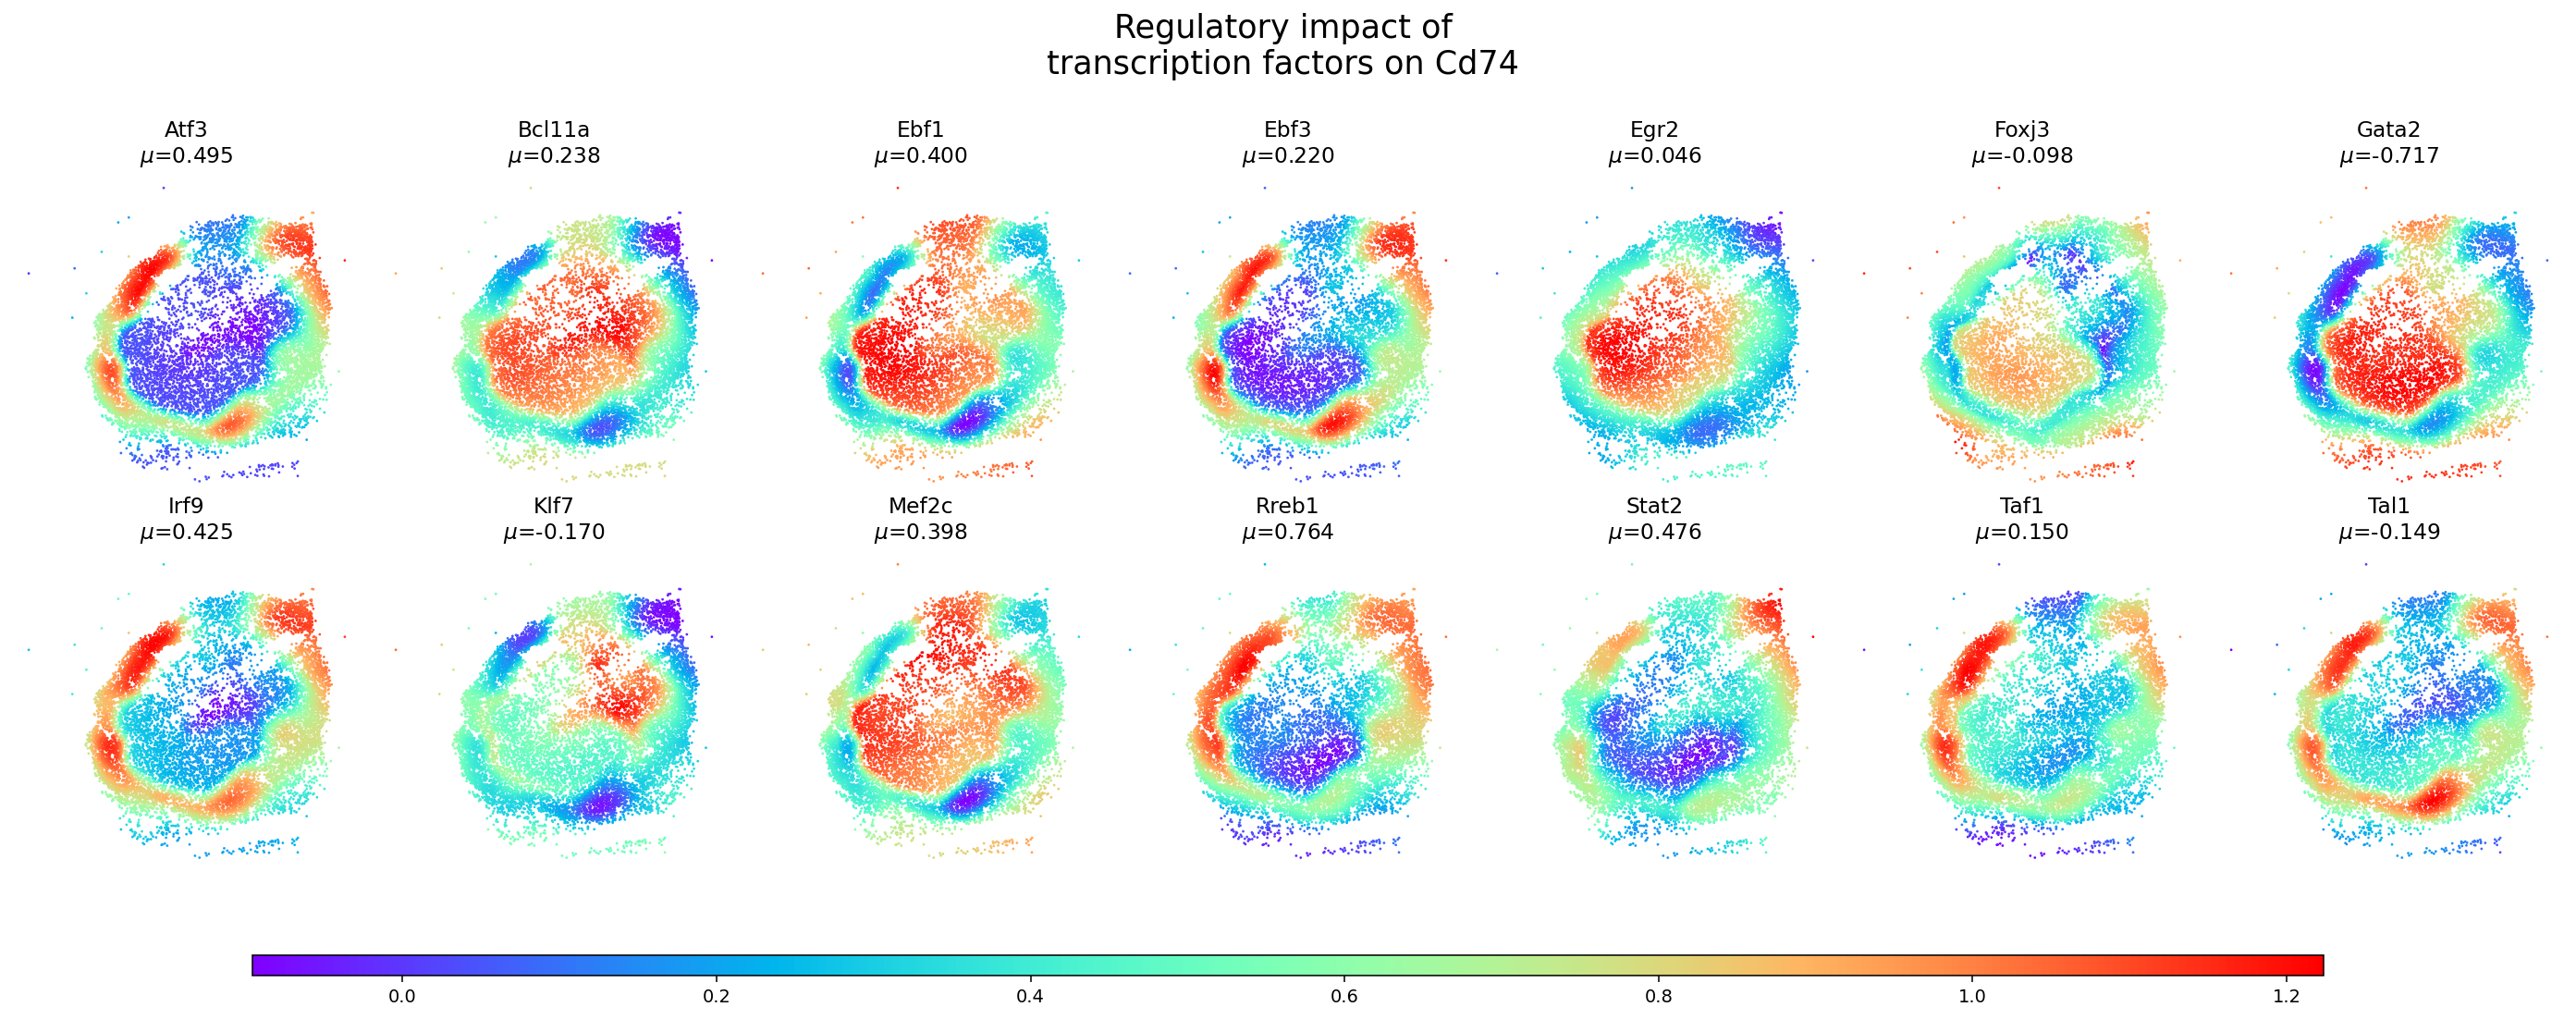

In [25]:
f, axs = plt.subplots(2, 7, figsize=(20, 8), dpi=140, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata.obsm['spatial'][:, 0], y=adata.obsm['spatial'][:, 1], 
                s=2, c=betas[:, i+1], cmap='rainbow', 
                ax=axs[i], edgecolor=None, linewidth=0, 
    )
    scatter_plots.append(scatter)

beta_means = list(betas.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{estimator.regulators[ix]}\n'+ r'$\mu$' + f'={beta_means[ix+1]:.3f}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.tight_layout()
f.subplots_adjust(bottom=0.15)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(
    scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')


plt.suptitle(f'Regulatory impact of \ntranscription factors on {estimator.target_gene} ', fontsize=18)
plt.subplots_adjust(top=0.825)

plt.show()

In [ ]:
model.predict_y(model.betas, adata.X)